In [116]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [117]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = "data/dogbreed/"
sz = 224
# arch = resnext101_64
# arch=resnext50
arch = resnet34
bs = 58

In [6]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 
val_idxs = get_cv_idxs(n)

In [7]:
!ls {PATH}

labels.csv  nohup.out  sample_submission.csv  test  tmp  train


In [8]:
label_df = pd.read_csv("data/dogbreed/labels.csv")

In [9]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
label_df.pivot_table(index = "breed", aggfunc =len).sort_values('id', ascending = False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name = 'test', 
                                      val_idxs = val_idxs, suffix = '.jpg',
                                      tfms=tfms, bs=bs)
#learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [15]:
fn = PATH + data.trn_ds.fnames[6]; fn;

In [16]:
fn

'data/dogbreed/train/0042188c895a2f14ef64a918ed9c7b64.jpg'

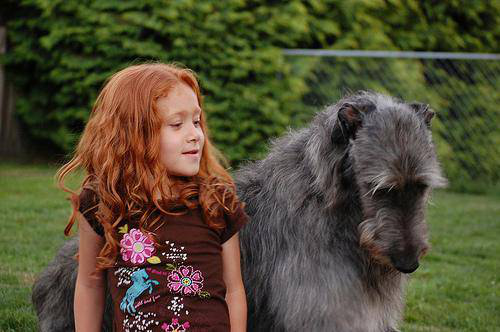

In [17]:
img = PIL.Image.open(fn); img

In [18]:
img.size

(500, 332)

In [19]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [20]:
row_sz, col_sz = list(zip(*size_d.values()))

In [21]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [22]:
row_sz[:5]

array([500, 500, 500, 500, 500])

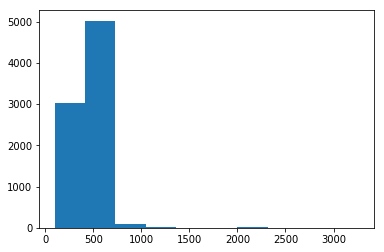

In [23]:
plt.hist(row_sz);

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

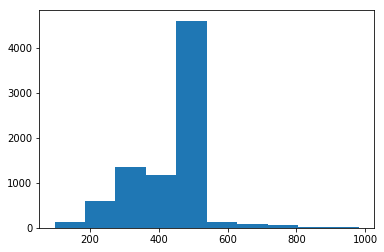

In [24]:
plt.hist(row_sz[row_sz < 1000])

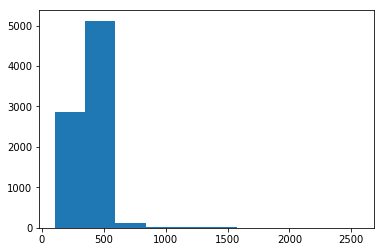

In [25]:
plt.hist(col_sz);

In [26]:
len(data.trn_ds)

8178

In [27]:
len(data.test_ds)

10357

# 3 Initial model

In [30]:
??data.resize

In [31]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom= 1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name = 'test', num_workers = 4,
                                      val_idxs = val_idxs, suffix = '.jpg', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [95]:
??ImageClassifierData.from_csv

In [98]:
??ConvLearner

## 3.1 Precompute

In [32]:
data = get_data(sz, bs)

In [33]:
arch=resnet101
learn = ConvLearner.pretrained(arch, data, precompute = True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/paperspace/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:06<00:00, 26151364.68it/s]


100%|██████████| 179/179 [01:09<00:00,  2.58it/s]


In [117]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                   
    0      2.04062    1.058029   0.772994  
    1      1.04267    0.712013   0.812133                   
    2      0.76133    0.650575   0.814579                    
    3      0.635442   0.598602   0.828278                    
    4      0.573444   0.553474   0.829256                    



[array([0.55347]), 0.8292563612447093]

In [34]:
learn.precompute = False

In [35]:
learn.fit(1e-2, 5, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.509735   0.811305   0.859589  
    1      0.843406   0.498341   0.885029                    
    2      0.647335   0.420744   0.887476                    
    3      0.552978   0.385987   0.887476                    
    4      0.484892   0.370145   0.892857                    



[array([0.37015]), 0.8928571510804842]

In [113]:
??learn.save

In [36]:
learn.save('224_pre')

In [115]:
??learn.save

In [37]:
learn.load('224_pre')

### 3.3 Increase size

In [38]:
learn.set_data(get_data(299,bs))
learn.freeze()

In [39]:
learn.fit(1e-2, 3, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.468348   0.344847   0.895303  
    1      0.413029   0.335241   0.899217                    
    2      0.375225   0.326048   0.901174                    



[array([0.32605]), 0.9011741699887815]

In [40]:
learn.fit(1e-2, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.359549   0.32599    0.900196  
    1      0.343246   0.31784    0.895793                    
    2      0.312965   0.311145   0.901174                    
    3      0.308604   0.330195   0.892857                    
    4      0.279017   0.318411   0.901663                    
    5      0.249463   0.309384   0.90411                     
    6      0.222852   0.310537   0.903131                    



[array([0.31054]), 0.9031311165096708]

In [41]:
log_preds,y = learn.TTA()

probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs, y)

0.9021526418786693

In [42]:
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9021526418786693, 0.30429011856677324)

In [43]:
learn.save('299_pre')

In [44]:
learn.load('299_pre')

In [160]:
learn.fit(1e-2, 1, cycle_len = 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.435217   0.42783    0.860568  
    1      0.406747   0.428482   0.863503                    



[array([0.42848]), 0.8635029367038182]

In [161]:
learn.save('299_pre')

In [162]:
log_preds,y = learn.TTA()

probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs, y)

accuracy_np(probs, y), metrics.log_loss(y, probs)

0.8747553816046967

### Scoring

In [45]:
test_preds = learn.TTA(is_test = True)

test_preds = np.exp(test_preds[0])

### Final Output

In [102]:
columns = pd.read_csv('~/data/dogbreed/sample_submission.csv', index_col='id').columns

test_submission = pd.DataFrame(test_preds[0])

test_submission.index = [i.split('.jpg')[0] for i in os.listdir(f'{PATH}/test')]

test_submission.index.name = 'id'

test_submission.to_csv("~/data/dogbreed/submission_20180516.csv", header = columns)

### Non TTA Scoring if preferred

In [58]:
log_preds_nonTTA_test = learn.predict()

test_preds_nonTTA = np.exp(log_preds_nonTTA_test)